# Training feature selection

## Background

A common issue with labelled training data is class imbalance, i.e. it has skewed class proportions. During model training, the algorithm will optimize over all training data, hence imbalanced training data may lead to a biased model. For example, the model is more likely to mis-classify a minority class as a majority class than the other way around.

In some cases, distribution of the training data is designed to match the true distribution of the classes, and the prediction is expected to bias against an infrequent class. In some other cases, accuray requirements are different for different classes. It is then desirable to adjust the porportions of the training labels to include more points for classes where commission error is preferred over omission error.

## Description

This notebook demonstrates how to explore class imbalance and correlations between the features extracted and adjust the data before using it to train a model.


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import json
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
from joblib import dump

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

## Load training data and label dictionary

We will load the training data saved from the [feature extracion notebook](3_Training_feature_extraction.ipynb), along with the mapping between crop labels and the numerical classes.

In [2]:
dataset_name = 'PD'
base_path = 'Input'
output_file = os.path.join(base_path, f'{dataset_name}_dataset.csv')
# Load the newly generated CSV file
df = pd.read_csv(output_file)
# print the number of rows
print(f"Number of rows: {len(df)}")

Number of rows: 4729


In [3]:
# Visualize the features in the dataset
features = df.columns
# Print the number of predictors
print(f'The number of features is: {len(features)}')
# List the potential predictors
print(features)

The number of features is: 60
Index(['FIELDID', 'Crop_type', 'Crop_num', 'Median', 'Mean', 'Std', 'Start',
       'End', 'Coverage', 'Year', 'week', 'chirps_mean_prec',
       'chirps_sum_prec', 'chirps_max_prec', 'chirps_min_prec',
       'chirps_std_prec', 'chirps_cnt_prec', 'RSM_mean', 'RSM_min', 'RSM_max',
       'era5_temp2m', 'era5_temp2mmin', 'era5_temp2max', 'era5_totprec',
       'era5_rh', 'era5_swi', 'era5_evaporation_from_bare_soil_sum',
       'veg_mean_evi', 'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi',
       'veg_mean_ndvi', 'veg_median_evi', 'veg_median_lai', 'veg_median_pvr',
       'veg_median_msi', 'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai',
       'veg_max_pvr', 'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi',
       'veg_min_lai', 'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi',
       'veg_std_evi', 'veg_std_lai', 'veg_std_pvr', 'veg_std_msi',
       'veg_std_ndvi', 'sar_vh', 'sar_vv', 'sar_angle', 'sar_sigma_vh_linear',
       'sar_sigma_vv_linear', 'sar_p_rati

## NDVI Threshold Filtering: >= 0.1

We filter out rows where the median NDVI (`veg_median_ndvi`) is below 0.2 to focus on time periods with significant vegetation. After filtering, we also calculate and print the number of removed rows.


The number of included rows is: 4712
The number of removed rows is: 17


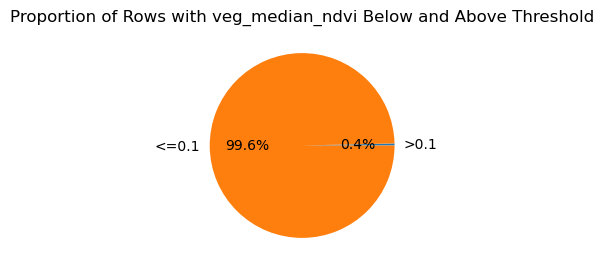

In [4]:
# pie chart of of rows with veg_median_ndvi < threshold and veg_median_ndvi >= threshold
# Calculate the number of rows with veg_median_ndvi < threshold and veg_median_ndvi >= threshold
ndvi_threshold = 0.1
# Remove rows with veg_median_ndvi < threshold
df1 = df[df['veg_median_ndvi'] >= ndvi_threshold]
# Print the number of included rows
print(f'The number of included rows is: {df1.shape[0]}')
# Print the number of removed rows
print(f'The number of removed rows is: {df.shape[0] - df1.shape[0]}')
below_threshold = df[df['veg_median_ndvi'] < ndvi_threshold].shape[0]
above_threshold = df[df['veg_median_ndvi'] >= ndvi_threshold].shape[0]
# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie([below_threshold, above_threshold], labels=['>' + str(ndvi_threshold), '<=' + str(ndvi_threshold)], autopct='%1.1f%%')
plt.title('Proportion of Rows with veg_median_ndvi Below and Above Threshold')
plt.show()


In [5]:
# Print the number of rows
print(f"Number of rows: {len(df1)}")

Number of rows: 4712


## Coverage Filtering: >= 60%

We filter out rows where the Coverage (`Coverage`) is below 90% to focus on parcels we are absolutely certain about the reported crop type. After filtering, we also calculate and print the number of removed rows.


In [6]:
# list 5 rows of the dataset in field Coverage
print(df1['Coverage'].head())

0    88.39
1    96.19
2    88.75
3    91.88
4    96.19
Name: Coverage, dtype: float64


The number of included rows is: 4358
The number of removed rows is: 354


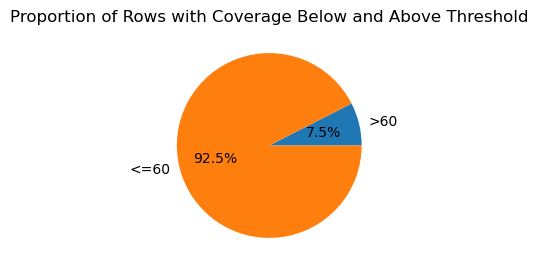

In [7]:
# pie chart of of rows with Coverage < threshold and Coverage >= threshold
# Calculate the number of rows with Coverage < threshold and Coverage >= threshold
cov_threshold = 60
# Remove rows with veg_median_ndvi < threshold
df2 = df1[df1['Coverage'] >= cov_threshold]
# Print the number of included rows
print(f'The number of included rows is: {df2.shape[0]}')
# Print the number of removed rows
print(f'The number of removed rows is: {df1.shape[0] - df2.shape[0]}')
below_threshold = df1[df1['Coverage'] < cov_threshold].shape[0]
above_threshold = df1[df1['Coverage'] >= cov_threshold].shape[0]
# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie([below_threshold, above_threshold], labels=['>' + str(cov_threshold), '<=' + str(cov_threshold)], autopct='%1.1f%%')
plt.title('Proportion of Rows with Coverage Below and Above Threshold')
plt.show()



### Inspect the label and feature columns

As shown below, we have over 40 features extracted.

In [8]:
# Calculate the number of predictors: columns after first 9 columns
predictors = df2.columns[10:]
# Print the number of predictors
print(f'The number of predictors is: {len(predictors)}')
# List the potential predictors
print(predictors)

The number of predictors is: 50
Index(['week', 'chirps_mean_prec', 'chirps_sum_prec', 'chirps_max_prec',
       'chirps_min_prec', 'chirps_std_prec', 'chirps_cnt_prec', 'RSM_mean',
       'RSM_min', 'RSM_max', 'era5_temp2m', 'era5_temp2mmin', 'era5_temp2max',
       'era5_totprec', 'era5_rh', 'era5_swi',
       'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi', 'veg_mean_lai',
       'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi', 'veg_median_evi',
       'veg_median_lai', 'veg_median_pvr', 'veg_median_msi', 'veg_median_ndvi',
       'veg_max_evi', 'veg_max_lai', 'veg_max_pvr', 'veg_max_msi',
       'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai', 'veg_min_pvr',
       'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi', 'veg_std_lai',
       'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 'sar_vh', 'sar_vv',
       'sar_angle', 'sar_sigma_vh_linear', 'sar_sigma_vv_linear',
       'sar_p_ratio', 'sar_rvi', 'sar_rcspr'],
      dtype='object')


In [9]:
# Let's assume you have more data for different weeks. You need to calculate the derivatives for each field over time.
# Sorting by 'field_key', 'year', and 'week' to ensure correct temporal ordering
df2 = df2.sort_values(by=['FIELDID', 'Year', 'week'])

# Group by 'field_key' and 'year' to calculate derivatives for each parcel (field) independently
df2['ndvi_delta1'] = df2.groupby(['FIELDID', 'Year'])['veg_mean_ndvi'].diff() / df2.groupby(['FIELDID', 'Year'])['week'].diff()
df2['evi_delta1'] = df2.groupby(['FIELDID', 'Year'])['veg_mean_evi'].diff() / df2.groupby(['FIELDID', 'Year'])['week'].diff()
df2['msi_delta1'] = df2.groupby(['FIELDID', 'Year'])['veg_mean_msi'].diff() / df2.groupby(['FIELDID', 'Year'])['week'].diff()
df2['lai_delta1'] = df2.groupby(['FIELDID', 'Year'])['veg_mean_lai'].diff() / df2.groupby(['FIELDID', 'Year'])['week'].diff()
df2['pvr_delta1'] = df2.groupby(['FIELDID', 'Year'])['veg_mean_pvr'].diff() / df2.groupby(['FIELDID', 'Year'])['week'].diff()


# remove rows with NaN values
df2 = df2.dropna()
print(df2.shape)
# Calculate the second derivative (acceleration of NDVI)
# df2['ndvi_delta2'] = df2.groupby(['FIELDID', 'Year'])['ndvi_delta1'].diff() / df.groupby(['FIELDID', 'Year'])['week'].diff()


(4104, 65)


In [10]:
# Calculate the number of predictors: columns after first 9 columns
predictors = df2.columns[9:]
# Print the number of predictors
print(f'The number of predictors is: {len(predictors)}')
# List the potential predictors
print(predictors)

The number of predictors is: 56
Index(['Year', 'week', 'chirps_mean_prec', 'chirps_sum_prec',
       'chirps_max_prec', 'chirps_min_prec', 'chirps_std_prec',
       'chirps_cnt_prec', 'RSM_mean', 'RSM_min', 'RSM_max', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 'sar_vh',
       'sar_vv', 'sar_angle', 'sar_sigma_vh_linear', 'sar_sigma_vv_linear',
       'sar_p_ratio', 'sar_rvi', 'sar_rcspr', 'ndvi_delta1', 'evi_delta1',
       'msi_delta1', 'lai_delta1', 'p

## Class rebalancing

We first inspect the number of samples per class and notice we have significant larger number of "Others" class than the single crop classes.

Crop_type
Maize    3402
Soy       702
Name: count, dtype: int64


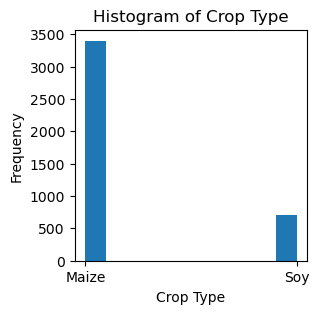

In [11]:
# Investigate value counts for each class in Crop_type
print(df2['Crop_type'].value_counts())
# Plot the histogram of Crop_type with labels
plt.figure(figsize=(3, 3))
plt.hist(df2['Crop_type'])
plt.xlabel('Crop Type')
plt.ylabel('Frequency')
plt.title('Histogram of Crop Type')
plt.show()

We then reduce the number of samples for classes with significantly larger sample size than the other classes. In this case, we will allow sample size within 10 times the smallest sample.

> We are not making all sample sizes same because we want to preserve the large number of Maize, Sesame and Others samples to capture intra-class diversity. 

In [12]:
boosting_factor = 5;

# Calculate the minimum and maximum frequency
min_freq = df2['Crop_type'].value_counts().min()
print(f'The minimum frequency in Crop_type is: {min_freq}')

# Determine the maximum allowed frequency for any Crop_type
max_freq = min_freq * boosting_factor
print(f'The maximum frequency for the remaining crop types is: {max_freq}')

# Adjust the DataFrame to ensure no Crop_type exceeds the max frequency
def limit_crop_type_frequency(df2, max_freq):
    # Initialize an empty list to hold the DataFrame chunks
    df_list = []

    # Group by Crop_type and process each group
    for crop_type, group in df2.groupby('Crop_type'):
        if len(group) > max_freq:
            # Randomly sample the maximum allowed number of rows
            group = group.sample(n=max_freq, random_state=1)
        # Append the group to the list
        df_list.append(group)

    # Concatenate all the processed groups back into a single DataFrame
    return pd.concat(df_list)

# Apply the function to limit the frequencies
df_limited = limit_crop_type_frequency(df2, max_freq)

# Print the new value counts to verify
print(df_limited['Crop_type'].value_counts())


The minimum frequency in Crop_type is: 702
The maximum frequency for the remaining crop types is: 3510
Crop_type
Maize    3402
Soy       702
Name: count, dtype: int64


Crop_type
Maize    3402
Soy       702
Name: count, dtype: int64


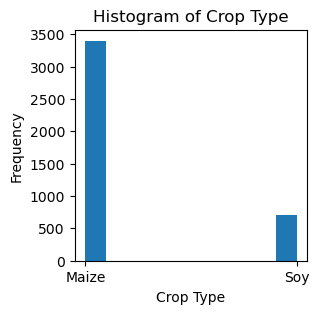

In [13]:
# Investigate value counts for each class in Crop_type
print(df_limited['Crop_type'].value_counts())
# Plot the histogram of Crop_type with labels
plt.figure(figsize=(3, 3))
plt.hist(df_limited['Crop_type'])
plt.xlabel('Crop Type')
plt.ylabel('Frequency')
plt.title('Histogram of Crop Type')
plt.show()

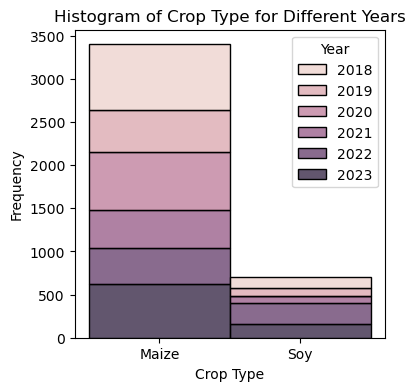

In [14]:
# Suppress the specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plot the histogram of Crop_type for different years
plt.figure(figsize=(4, 4))
sns.histplot(data=df_limited, x='Crop_type', hue='Year', multiple='stack')
plt.xlabel('Crop Type')
plt.ylabel('Frequency')
plt.title('Histogram of Crop Type for Different Years')
plt.show()




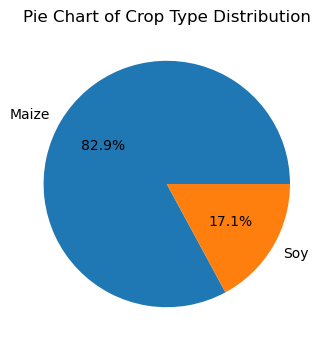

In [15]:
# Plot a pie chart of the Crop_type distribution 
plt.figure(figsize=(4, 4))
plt.pie(df_limited['Crop_type'].value_counts(), labels=df_limited['Crop_type'].value_counts().index, autopct='%1.1f%%')
plt.title('Pie Chart of Crop Type Distribution')
plt.show()


In [16]:
# Save df_limited to a new CSV file
out_path = 'Input'
# use boosting factor in the output filename
output_filename = os.path.join(out_path, f'{dataset_name}_n1_c{boosting_factor}_delta.csv')
df_limited.to_csv(output_filename, index=False)